In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
random_state = 42

from sklearn.ensemble import GradientBoostingRegressor as GB
GBR = GB(random_state=random_state)
from sklearn.model_selection import cross_val_score

import optuna
from sklearn.metrics import r2_score


In [2]:
data = pd.read_csv('dataset_5300_T_h_600K.csv')
data = data.drop(['n_type_n', 'p_type_p'], axis=1)
data = data.dropna()
data.head()

,a,h,R,T_h,eta,mc_p,mDOS_p,tau_eff_p,n_i_p,eta_F_p,...,mDOS_n,tau_eff_n,n_i_n,eta_F_n,E_g_n,mDOS_min_n,kappa_L_300_n,Cp_n,rho_n,epsilon_n
0,1.0,2.0,0.011,811,5.569026,1.05,5.07,8.734208,5.159205e+20,0.08,...,0.92,19.548875,5.369622e+19,0.1,0.533873,5.07,17.5,307.5,8450,48.659
1,1.0,2.0,0.011,760,4.890687,1.05,5.07,8.734208,5.159205e+20,0.08,...,0.92,19.548875,5.369622e+19,0.1,0.533873,5.07,17.5,307.5,8450,48.659
2,1.0,2.0,0.011,690,3.960808,1.05,5.07,8.734208,5.159205e+20,0.08,...,0.92,19.548875,5.369622e+19,0.1,0.533873,5.07,17.5,307.5,8450,48.659
3,1.0,2.0,0.168,811,1.324396,1.05,5.07,8.734208,5.159205e+20,0.08,...,0.92,19.548875,5.369622e+19,0.1,0.533873,5.07,17.5,307.5,8450,48.659
4,1.0,2.0,0.168,760,1.112544,1.05,5.07,8.734208,5.159205e+20,0.08,...,0.92,19.548875,5.369622e+19,0.1,0.533873,5.07,17.5,307.5,8450,48.659


In [4]:
data.columns

Index(['a', 'h', 'R', 'T_h', 'eta', 'mc_p', 'mDOS_p', 'tau_eff_p', 'n_i_p',
       'eta_F_p', 'E_g_p', 'mDOS_min_p', 'kappa_L_300_p', 'Cp_p', 'rho_p',
       'epsilon_p', 'mc_n', 'mDOS_n', 'tau_eff_n', 'n_i_n', 'eta_F_n', 'E_g_n',
       'mDOS_min_n', 'kappa_L_300_n', 'Cp_n', 'rho_n', 'epsilon_n'],
      dtype='object')

## feature engineering


In [3]:

data['\u03BA_L_300_n'] = data['kappa_L_300_n']
data['\u03BA_L_300_p'] = data['kappa_L_300_p']
data['\u03C1_n'] = data['rho_n']
data['\u03C1_p'] = data['rho_p']
data['\u03B5_n'] = data['epsilon_n']
data['\u03B5_p'] = data['epsilon_p']
data['\u03B7'] = data['eta']
#tau
data['\u03C4_eff_n'] = data['tau_eff_n']
data['\u03C4_eff_p'] = data['tau_eff_p']


# rewrite data by adding new features
data = data.reindex(columns=['\u03C4_eff_p', '\u03C4_eff_n',
                             'mc_p', 'mc_n',
                             'n_i_n', 'n_i_p',
                             'E_g_n','E_g_p',
                             '\u03BA_L_300_n', '\u03BA_L_300_p',
                             'R', 'T_h', 
                             'h', 'a',
                             'Cp_n', 'Cp_p',
                             '\u03C1_p','\u03C1_n', 
                             '\u03B5_n','\u03B5_p',
                             'mDOS_n','mDOS_p', 
                             'mDOS_min_n','mDOS_min_p',
                             '\u03B7',
                             #'eta'
                                ])

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5323 entries, 0 to 5322
Data columns (total 25 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   τ_eff_p     5323 non-null   float64
 1   τ_eff_n     5323 non-null   float64
 2   mc_p        5323 non-null   float64
 3   mc_n        5323 non-null   float64
 4   n_i_n       5323 non-null   float64
 5   n_i_p       5323 non-null   float64
 6   E_g_n       5323 non-null   float64
 7   E_g_p       5323 non-null   float64
 8   κ_L_300_n   5323 non-null   float64
 9   κ_L_300_p   5323 non-null   float64
 10  R           5323 non-null   float64
 11  T_h         5323 non-null   int64  
 12  h           5323 non-null   float64
 13  a           5323 non-null   float64
 14  Cp_n        5323 non-null   float64
 15  Cp_p        5323 non-null   float64
 16  ρ_p         5323 non-null   int64  
 17  ρ_n         5323 non-null   int64  
 18  ε_n         5323 non-null   float64
 19  ε_p         5323 non-null  

<AxesSubplot:>

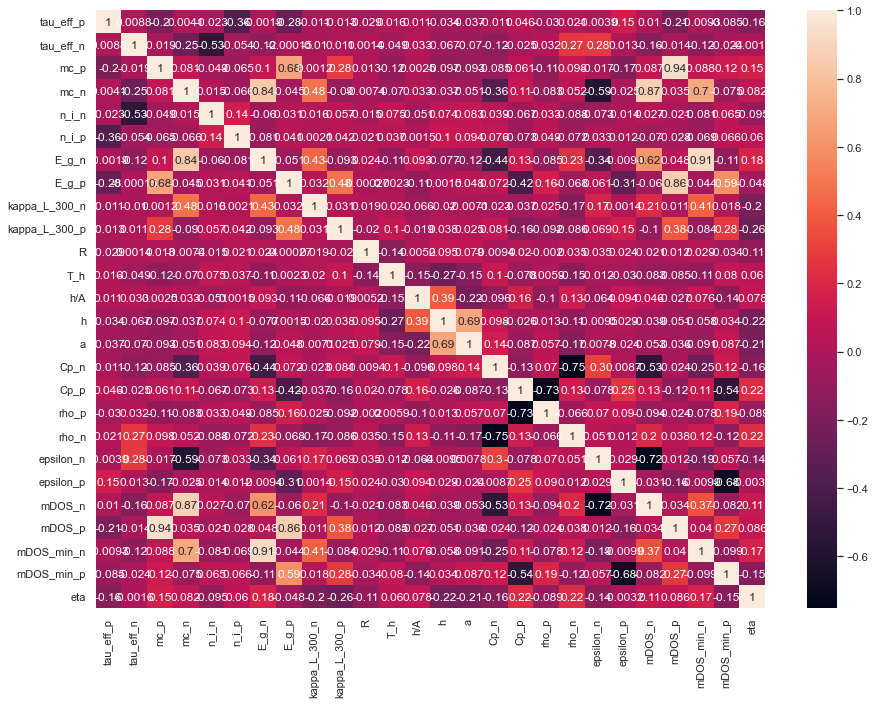

In [7]:
sns.set_theme()
fig = plt.subplots(figsize=(15,11))  
sns.heatmap(data.corr(), annot=True, xticklabels='auto', yticklabels='auto')

create the feature matrix "X" (physical props and operation conditions) and target vector "y" (TEG efficiency, column "eta")

In [5]:
X = data.drop(['\u03B7'], axis=1)
y = data['\u03B7']

In [6]:
col_names = X.columns

split into test and train datasets

In [7]:
X_for_train, X_test, y_for_train, y_test = train_test_split(X, y, test_size = 0.1, 
                                                   random_state = random_state)

X_train, X_val, y_train, y_val = train_test_split(X_for_train, y_for_train, test_size = 0.1, 
                                                   random_state = random_state)

## 1. baseline: Gradient Boosting with default hyperparameters on all features

In [7]:
GBR.fit(X_train, y_train)
print("\nGradient boosting R2 score with default settings: ", round(GBR.score(X_test, y_test), 3) )

cv_scores_GB = cross_val_score(GBR, X_train, y_train, cv=5, scoring='r2')
print(
    "\nGradient boosting CV_R2 score with default settings: ", 
      round(cv_scores_GB.mean(), 3) 
     )



Gradient boosting R2 score with default settings:  0.806

Gradient boosting CV_R2 score with default settings:  0.787


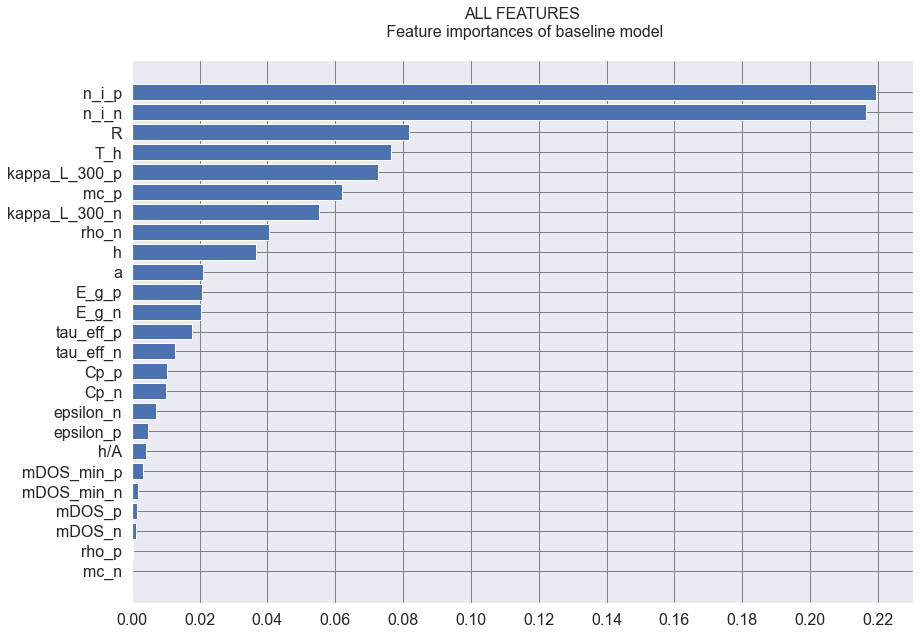

In [12]:

sorted_indices = np.argsort(GBR.feature_importances_)
sorted_importances = GBR.feature_importances_[sorted_indices]
sorted_features = X_train.columns[sorted_indices]


plt.figure(figsize=(14,10))
plt.xticks(np.arange(0.0, 0.3, 0.02), fontsize=16)
plt.grid(True, color='grey', which='both')
plt.title('ALL FEATURES\n Feature importances of baseline model\n', fontsize=16)
plt.barh(np.arange(len(sorted_importances)), sorted_importances)
plt.yticks(np.arange(len(sorted_features)), sorted_features, fontsize=16)
plt.show()

## 2. Optimized Gradient Boosting on all features 

In [9]:
!pip install optuna


In [8]:
def objective(trial):
    # Define search space
    param_gb = {
        'learning_rate': trial.suggest_float('learning_rate', 0.04, 0.25),
        'n_estimators': trial.suggest_int('n_estimators', 350, 600),
        'max_depth': trial.suggest_int('max_depth', 1, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 30, 40),
        #'subsample' : trial.suggest_float('subsample', 0.8, 1.0),
        'min_samples_split' : trial.suggest_int('min_samples_split', 2, 40)
    }
    # Create model
    model = GB(**param_gb)
    # Fit model
    model.fit(X_train, y_train)
    # Evaluate model
    y_pred = model.predict(X_val)
    return r2_score(y_val, y_pred)


# Perform hyperparameter optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# Get the best parameters
best_params_gb = study.best_params

[I 2024-07-25 20:12:17,365] A new study created in memory with name: no-name-556eb87a-aa37-4820-92c6-408947a4dfa4
[I 2024-07-25 20:12:23,244] Trial 0 finished with value: 0.9610430129544982 and parameters: {'learning_rate': 0.12958213516793743, 'n_estimators': 479, 'max_depth': 6, 'min_samples_leaf': 36, 'min_samples_split': 26}. Best is trial 0 with value: 0.9610430129544982.
[I 2024-07-25 20:12:27,236] Trial 1 finished with value: 0.9550418309484369 and parameters: {'learning_rate': 0.207114006511321, 'n_estimators': 410, 'max_depth': 5, 'min_samples_leaf': 34, 'min_samples_split': 19}. Best is trial 0 with value: 0.9610430129544982.
[I 2024-07-25 20:12:35,454] Trial 2 finished with value: 0.9715053525112612 and parameters: {'learning_rate': 0.2069482414390154, 'n_estimators': 423, 'max_depth': 13, 'min_samples_leaf': 38, 'min_samples_split': 33}. Best is trial 2 with value: 0.9715053525112612.
[I 2024-07-25 20:12:43,333] Trial 3 finished with value: 0.9636273220616244 and parameters

In [9]:
best_params_gb

{'learning_rate': 0.18066732724592738,
 'n_estimators': 452,
 'max_depth': 16,
 'min_samples_leaf': 37,
 'min_samples_split': 24}

In [10]:

GBR_opt = GB(**best_params_gb,
             random_state = random_state)
GBR_opt.fit(X_train, y_train)

best_score_GB = GBR_opt.score(X_test, y_test)
print("\noptimized Gradient boosting R2 score\n: ", round(best_score_GB, 3) )



optimized Gradient boosting R2 score
:  0.972


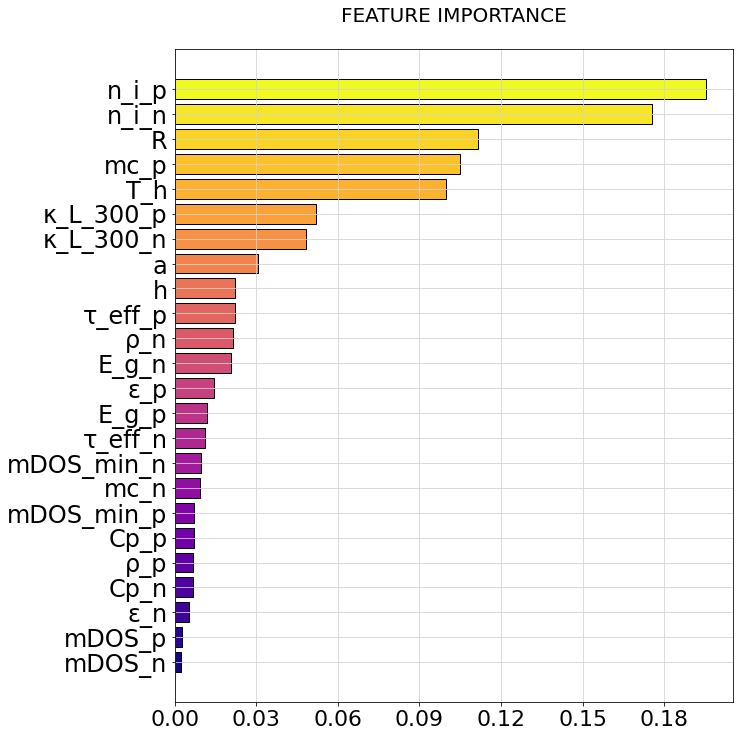

In [11]:
sorted_indices = np.argsort(GBR_opt.feature_importances_)
sorted_importances = GBR_opt.feature_importances_[sorted_indices]
sorted_features = X_train.columns[sorted_indices]

import matplotlib.cm as cm

plt.figure(figsize=(10,12))
plt.xticks(np.arange(0.0, 0.3, 0.03), fontsize=22)
plt.yticks( fontsize=24)
plt.grid(True, color='lightgrey', which='both')

plt.title('FEATURE IMPORTANCE\n', fontsize=20)

cmap = cm.get_cmap('plasma', len(sorted_importances))

# Plot each bar with a different color from the colormap
for i in range(len(sorted_importances)):
    plt.barh(i, sorted_importances[i], color=cmap(i / len(sorted_importances)),  edgecolor='black')

#     plt.text(0.95, 0.5, 'Averaging over 300 \u2014 600 K', 
#          verticalalignment='center', horizontalalignment='right', 
#          transform=plt.gca().transAxes, fontsize=20, weight='light')
    
plt.yticks(np.arange(len(sorted_features)), sorted_features, fontsize=24)
plt.show()

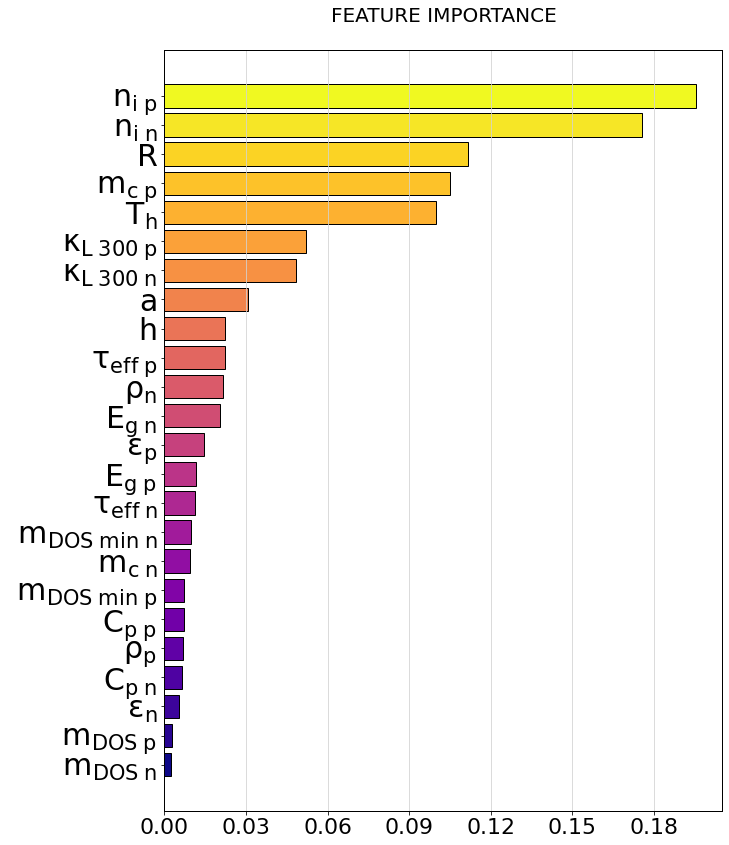

In [13]:
custom_labels = [r' $\mathregular{m_{DOS\;n}}$',
                 r' $\mathregular{m_{DOS\;p}}$',
                 r' $\mathregular{\epsilon_{n}}$',
                 r' $\mathregular{C_{p\;n}}$', 
                 r' $\mathregular{\rho_{p}}$',
                 r' $\mathregular{C_{p\;p}}$',
                 r' $\mathregular{m_{DOS\;min\;p}}$',
                 r' $\mathregular{m_{c\;n}}$', 
                 r' $\mathregular{m_{DOS\;min\;n}}$',
                 r' $\mathregular{\tau_{eff\;n}}$',
                 r' $\mathregular{E_{g\; p}}$',
                 r' $\mathregular{\epsilon_{p}}$', 
                 r' $\mathregular{E_{g\; n}}$',
                 r' $\mathregular{\rho_{n}}$',
                 r' $\mathregular{\tau_{eff\;p}}$',
                 'h',
                 'a',
                 r' $\mathregular{\kappa_{L\; 300\; n}}$',
                 r' $\mathregular{\kappa_{L\; 300\; p}}$',
                 r' $\mathregular{T_{h}}$', 
                 r' $\mathregular{m_{c\;p}}$', 
                 "R",  
                 r' $\mathregular{n_{i\; n}}$',
                 r' $\mathregular{n_{i\; p}}$',
                 ] 

plt.figure(figsize=(10, 14), facecolor='white')
ax = plt.gca()  # Get current axes
ax.set_facecolor('white')
plt.xticks(np.arange(0.0, 0.3, 0.03), fontsize=22)
plt.yticks( fontsize=28)
plt.grid(True, color='lightgrey', axis='x')

plt.title('FEATURE IMPORTANCE\n', fontsize=20)

cmap = cm.get_cmap('plasma', len(sorted_importances))

# Plot each bar with a different color from the colormap
for i in range(len(sorted_importances)):
    plt.barh(i, sorted_importances[i], color=cmap(i / len(sorted_importances)),  edgecolor='black')

plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
plt.gca().spines['left'].set_visible(True)
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1)   
    
plt.yticks(np.arange(len(sorted_features)), custom_labels, fontsize=30)
plt.show()

Features importance

## 3.  FEATURES SELECTION

In [14]:
data = pd.read_csv('dataset_5300_T_h_600K.csv')
data = data.drop(['n_type_n', 'p_type_p'], axis=1)
data = data.dropna()
data['h/A'] = data['h'] / data['a'] * 2

data['\u03BA_L_300_n'] = data['kappa_L_300_n']
data['\u03BA_L_300_p'] = data['kappa_L_300_p']
data['\u03C1_n'] = data['rho_n']
data['\u03C1_p'] = data['rho_p']
data['\u03B5_n'] = data['epsilon_n']
data['\u03B5_p'] = data['epsilon_p']
data['\u03B7'] = data['eta']

data = data.reindex(columns=[#'tau_eff_p', 'tau_eff_n',
                             #'mc_p', 'mc_n',
                             'n_i_n', 'n_i_p',
                             'E_g_n','E_g_p',
                             #'\u03BA_L_300_n', '\u03BA_L_300_p',
                             
                             'R', 
                             'T_h', 
                             #'h/A', 
                             'h', 
                             # 'a',
                             
                             #'Cp_n', 'Cp_p',
                             #'rho_p','rho_n', 
                             #'epsilon_n','epsilon_p',
                             
                             #'mDOS_n','mDOS_p', 
                             #'mDOS_min_n','mDOS_min_p',
                             '\u03B7'])

X = data.drop(['\u03B7'], axis=1)
y = data['\u03B7']
cols_names = X.columns

X_for_train, X_test, y_for_train, y_test = train_test_split(X, y, test_size = 0.1, 
                                                   random_state = random_state)

X_train, X_val, y_train, y_val = train_test_split(X_for_train, y_for_train, test_size = 0.15, 
                                                   random_state = random_state)

In [15]:
# hyperparameters optimization
def objective(trial):
    # Define search space
    param_gb = {
        'learning_rate': trial.suggest_float('learning_rate', 0.04, 0.25),
        'n_estimators': trial.suggest_int('n_estimators', 350, 600),
        'max_depth': trial.suggest_int('max_depth', 1, 15),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 30, 40),
        #'subsample' : trial.suggest_float('subsample', 0.8, 1.0),
        'min_samples_split' : trial.suggest_int('min_samples_split', 2, 40)
    }
    # Create model
    model = GB(**param_gb)
    # Fit model
    model.fit(X_train, y_train)
    # Evaluate model
    y_pred = model.predict(X_val)
    return r2_score(y_val, y_pred)


# Perform hyperparameter optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# Get the best parameters
best_params_gb = study.best_params

[I 2024-07-25 20:24:20,488] A new study created in memory with name: no-name-ef64fa27-c02c-4814-ba97-70dac3c2b6b5
[I 2024-07-25 20:24:21,259] Trial 0 finished with value: 0.8106187821144191 and parameters: {'learning_rate': 0.13189849450063473, 'n_estimators': 452, 'max_depth': 2, 'min_samples_leaf': 40, 'min_samples_split': 17}. Best is trial 0 with value: 0.8106187821144191.
[I 2024-07-25 20:24:22,658] Trial 1 finished with value: 0.9420686121688857 and parameters: {'learning_rate': 0.17046110908555392, 'n_estimators': 379, 'max_depth': 5, 'min_samples_leaf': 30, 'min_samples_split': 38}. Best is trial 1 with value: 0.9420686121688857.
[I 2024-07-25 20:24:25,628] Trial 2 finished with value: 0.9726200534877731 and parameters: {'learning_rate': 0.1387518311113667, 'n_estimators': 418, 'max_depth': 15, 'min_samples_leaf': 34, 'min_samples_split': 5}. Best is trial 2 with value: 0.9726200534877731.
[I 2024-07-25 20:24:28,947] Trial 3 finished with value: 0.9699812161214474 and parameter

In [16]:
best_params_gb

{'learning_rate': 0.2446776150571317,
 'n_estimators': 503,
 'max_depth': 15,
 'min_samples_leaf': 33,
 'min_samples_split': 7}

In [17]:
GBR_opt = GB(**best_params_gb,
             random_state = random_state)
GBR_opt.fit(X_train, y_train)

best_score_GB = GBR_opt.score(X_test, y_test)
print("\noptimized Gradient boosting R2 score\n: ", round(best_score_GB, 3) )



optimized Gradient boosting R2 score
:  0.977


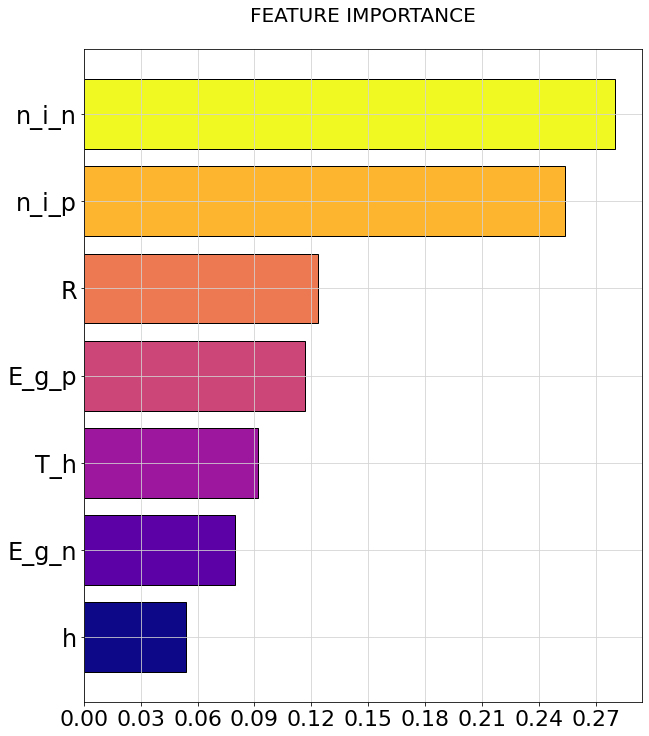

In [18]:
sorted_indices = np.argsort(GBR_opt.feature_importances_)
sorted_importances = GBR_opt.feature_importances_[sorted_indices]
sorted_features = X_train.columns[sorted_indices]

import matplotlib.cm as cm

plt.figure(figsize=(10,12))
plt.xticks(np.arange(0.0, 0.3, 0.03), fontsize=22)
plt.yticks( fontsize=24)
plt.grid(True, color='lightgrey', which='both')

plt.title('FEATURE IMPORTANCE\n', fontsize=20)

cmap = cm.get_cmap('plasma', len(sorted_importances))

for i in range(len(sorted_importances)):
    plt.barh(i, sorted_importances[i], color=cmap(i / len(sorted_importances)),  edgecolor='black')
    
plt.yticks(np.arange(len(sorted_features)), sorted_features, fontsize=24)
plt.show()

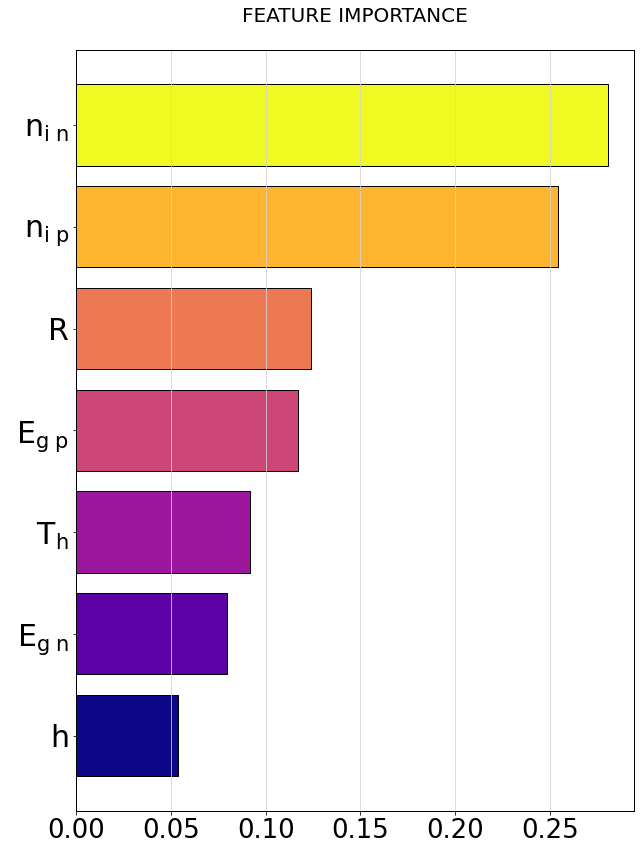

In [20]:
custom_labels = ['h',
                 r' $\mathregular{E_{g\; n}}$',
                 r' $\mathregular{T_{h}}$',
                 r' $\mathregular{E_{g\; p}}$',
                 "R",  
                 
                 r' $\mathregular{n_{i\; p}}$',
                 r' $\mathregular{n_{i\; n}}$',
                 ] 

plt.figure(figsize=(10, 14), facecolor='white')
ax = plt.gca()  # Get current axes
ax.set_facecolor('white')
plt.xticks(np.arange(0.0, 0.3, 0.05), fontsize=26)
plt.yticks( fontsize=28)
plt.grid(True, color='lightgrey', axis='x')

plt.title('FEATURE IMPORTANCE\n', fontsize=20)

cmap = cm.get_cmap('plasma', len(sorted_importances))

# Plot each bar with a different color from the colormap
for i in range(len(sorted_importances)):
    plt.barh(i, sorted_importances[i], color=cmap(i / len(sorted_importances)),  edgecolor='black')

plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
plt.gca().spines['left'].set_visible(True)
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1)   
    
plt.yticks(np.arange(len(sorted_features)), custom_labels, fontsize=30)
plt.show()

In [21]:
from collections import OrderedDict

feature_importances = {}
sum_of_importances = 0
for feature, importance in zip(sorted_features, sorted_importances):
    feature_importances[feature] = importance
feature_importances = OrderedDict(sorted(feature_importances.items()))

In [1]:
features = list(feature_importances.keys())
importances = list(feature_importances.values())
colors = plt.cm.Set3(range(len(features)))  # Using a colormap for diverse colors

NameError: name 'feature_importances' is not defined

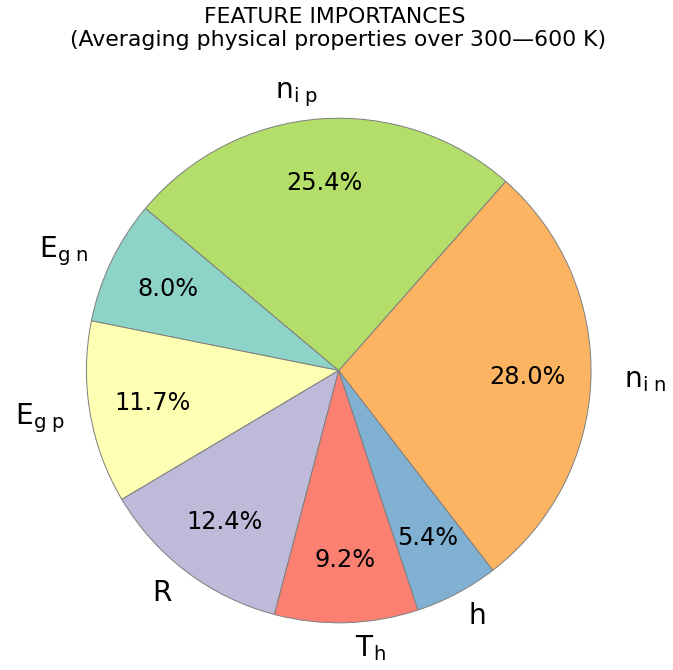

In [25]:
custom_labels = [r' $\mathregular{E_{g\; n}}$',
                 r' $\mathregular{E_{g\; p}}$',
                 "R",
                 r' $\mathregular{T_{h}}$', 
                 'h',
                 r' $\mathregular{n_{i\; n}}$',
                 r' $\mathregular{n_{i\; p}}$',] 

plt.figure(figsize=(10, 10))  # Adjust the figure size if necessary
wedges, texts, autotexts = plt.pie(importances, labels=custom_labels, autopct='%1.1f%%', startangle=140,
                                   colors=colors, textprops={'fontsize': 28},
                                   wedgeprops={'linewidth': 1, 'edgecolor': 'gray'},
                                   pctdistance=0.75)

# Customize the text and autopct appearance
for text in texts:
    text.set_color('black')
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(24)
    autotext.set_weight('light')

# Set the title with improved formatting
plt.title('FEATURE IMPORTANCES \n(Averaging physical properties over 300\u2014600 K)\n\n', fontsize=22, weight='light')

# Ensure the pie chart is drawn as a circle
plt.axis('equal')

# Display the plot
plt.show()